## Project: Face Detection using SSD-MobileNet-v2 Trained on WIDER FACE Dataset

The objective of this project is to demonstrate how to use the state of the art in object detection!
* It is not straight forward to reasonably train the SSD-MobileNet-v2 network from scratch, due to several reasons including:
  * Lack of large volume of annotated data
  * Lack of sufficiently powerful computing resources
* Instead of exploring the training of SSD-MobileNet-v2 from scratch we use an already trained model retrieved from the following source:

  * Trained SSD-MobileNet-v2 model source: https://github.com/Fszta/Tensorflow-face-detection

  * This model has been trained on the WIDER FACE dataset:
    * Source: http://shuoyang1213.me/WIDERFACE/
    * WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly available WIDER dataset. 
    * It has 32,203 images and label 393,703 faces with a high degree of variability in scale, pose and occlusion as depicted in the sample images. 
    * WIDER FACE dataset is organized based on 61 event classes. 
    * For each event class, we randomly select 40%/10%/50% data as training, validation and testing sets
    
* In this work, we shall demonstrate how to deploy the trained model to detect faces.

#### Author: Mohsen Ghazel (mghazel)
* Date: April 15th, 2021

### Step 1: Imports and global variables

#### 1.1) Python import:

In [4]:
#------------------------------------------------------
# Python imports and environment setup
#------------------------------------------------------
# opencv
import cv2
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# tensorflow
import tensorflow as tf

# utilities functionalities
from utils import label_map_util
# visualization utilities functionalities
from utils import visualization_utils_color as vis_util

# input/output OS
import os 

# date-time to show date and time
import datetime
# import time
import time

# to display the figures in the notebook
%matplotlib inline

#------------------------------------------
# Test imports and display package versions
#------------------------------------------
# Testing the OpenCV version
print("OpenCV : ",cv2.__version__)
# Testing the numpy version
print("Numpy : ",np.__version__)

OpenCV :  3.4.8
Numpy :  1.19.2


#### 1.2) Global constants:

In [5]:
#----------------------------------------------------------------
# Path to the trained SSD-MobileNet-v2 frozen detection graph:
#----------------------------------------------------------------
# This is the actual model that is used for the object detection.
PATH_TO_CKPT = './model/frozen_inference_graph.pb'

#----------------------------------------------------------------
# List of the strings that is used to add correct label for each 
# box.
#----------------------------------------------------------------
PATH_TO_LABELS = './proto/label_map.pbtxt'

#----------------------------------------------------------------
# Since the model was trained to detected human faces: 
#----------------------------------------------------------------
# Number of classes = 1: FACE
#----------------------------------------------------------------
NUM_CLASSES = 1

#----------------------------------------------------------------
# The detection confidence threshold: 
#----------------------------------------------------------------
# - Only detections with confidenece higher than this threshold 
#   are kept.
#----------------------------------------------------------------
DETECTION_CONFIDENCE_THRESHOLD = 0.50
#----------------------------------------------------------------
# Set test images folder name: 
#----------------------------------------------------------------
# Selected 10 test images from the WIDER-FACE TEST 
# data subset
#----------------------------------------------------------------
test_images_folder = 'images/wider-face--10-test-images/'

### Step 2: Implement the DL inference of the trained SSD-MobilenNet-v2 model:
* We now run deploy the trained SSD-MobileNet-v2 model to detect faces from test images
* Selected 10 test images from the WIDER-FACE TEST data subset

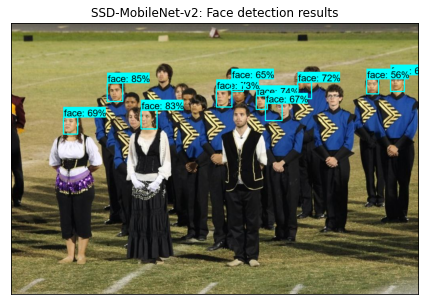

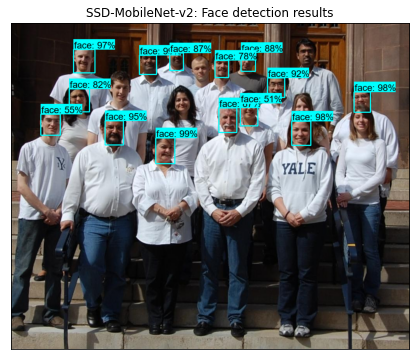

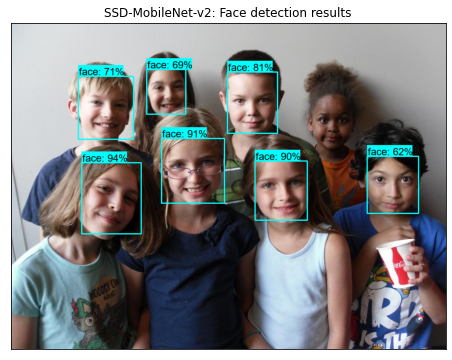

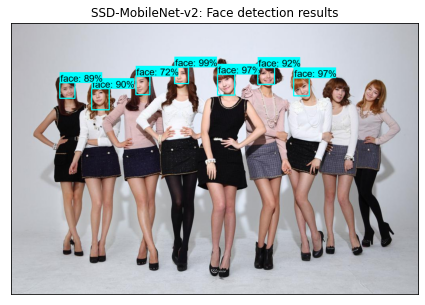

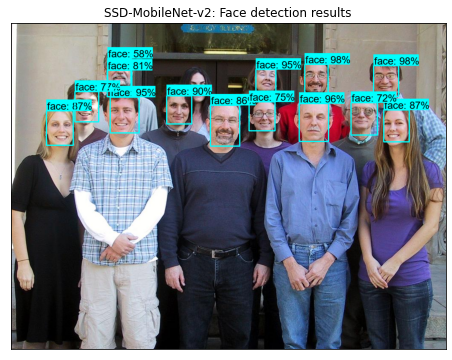

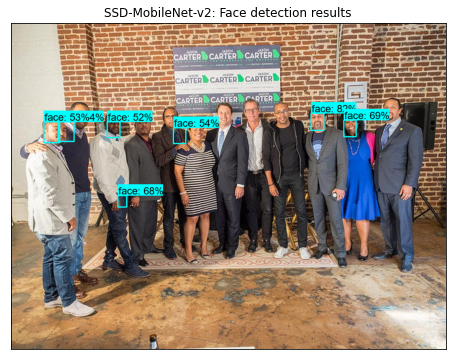

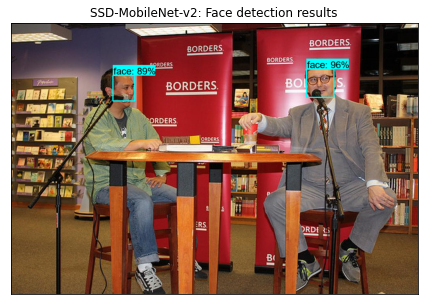

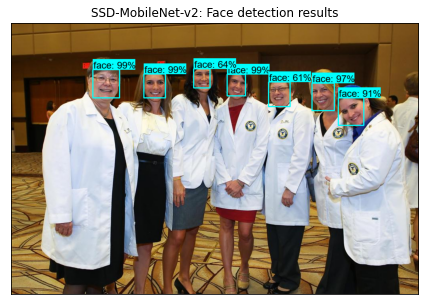

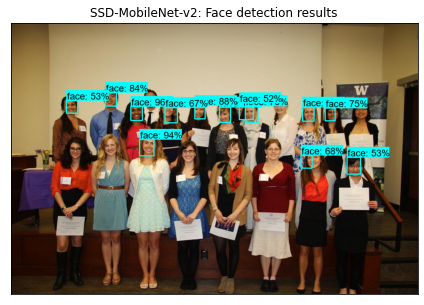

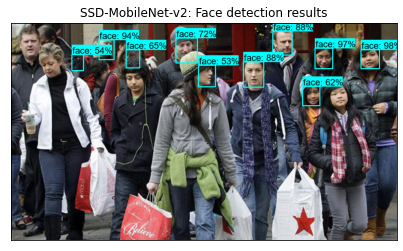

In [7]:
#----------------------------------------------------------------
# Load label map
#----------------------------------------------------------------
# - This allows us to map the class ID to class name
#----------------------------------------------------------------
# get the label-map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
# get the class categories/names
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
# get the class categories indices
category_index = label_map_util.create_category_index(categories)

#----------------------------------------------------------------
# Start the face detection inference:
#----------------------------------------------------------------
def face_detection():

    # Load Tensorflow model
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        #--------------------------------------------------------
        # FIX ERROR: AttributeError: module 'tensorflow' has no attribute 'GraphDef'
        #--------------------------------------------------------
        # tf.compat.v1.GraphDef()   # -> instead of tf.GraphDef()
        #--------------------------------------------------------
        # od_graph_def = tf.GraphDef()
        #--------------------------------------------------------
        od_graph_def = tf.compat.v1.GraphDef()
        #--------------------------------------------------------
        # FIX THE ERROR: AttributeError: module 'tensorflow' has no attribute 'gfile'
        #--------------------------------------------------------
        # 1.Find label_map_util.py line 137.
        # 2.Replace tf.gfile.GFile to tf.io.gfile.GFile
        #--------------------------------------------------------
        # with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        #--------------------------------------------------------
        with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        
        #--------------------------------------------------------
        # FIX ERROR: AttributeError: module 'tensorflow' has no attribute 'Session'
        #--------------------------------------------------------
        # According to TF 1:1 Symbols Map, in TF 2.0 you should use tf.compat.v1.Session() instead of tf.Session()
        #--------------------------------------------------------
        # sess = tf.Session(graph=detection_graph)
        #--------------------------------------------------------
        sess = tf.compat.v1.Session(graph=detection_graph)
        
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

    # Actual detection.
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')


    #------------------------------------------------------
    # Itetate over all the images in the test images 
    # folder, and detect human faces using the trained 
    # SSD-MobbileNET-ve model
    #------------------------------------------------------
    # initialize the image counter
    image_counter = 0
    for filename in os.listdir(test_images_folder):
        #------------------------------------------------------
        # read the test image
        #------------------------------------------------------
        frame = cv2.imread(os.path.join(test_images_folder,filename))
        # check if image was read properly
        if frame is not None:
            # increment the image counter
            image_counter = image_counter + 1
            #------------------------------------------------------
            # Deploy the YOLO model to conduct inference in 
            # the image
            #------------------------------------------------------
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            expanded_frame = np.expand_dims(frame, axis=0)
            (boxes, scores, classes, num_c) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: expanded_frame})

            #------------------------------------------------------
            # Visualization of the face detection results
            #------------------------------------------------------
            vis_util.visualize_boxes_and_labels_on_image_array(
                frame,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=3,
                min_score_thresh=DETECTION_CONFIDENCE_THRESHOLD)

            # display the frame with overlaid face detections results
            # create a figure
            plt.figure(figsize=(8, np.uint8(8 * frame.shape[0]/frame.shape[1])))
            # visualize detection results
            plt.subplot(111)
            plt.title("SSD-MobileNet-v2: Face detection results", fontsize=12)
            plt.xticks([]), plt.yticks([])
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            # save the image
            cv2.imwrite('images/face-detection-results/' + 'test-image-0' + str(image_counter) + '.jpg', frame) 
            
            

if __name__ == '__main__':
    face_detection()

### Step 7: Display a successful execution message

In [ ]:
# display a final message
# current time
now = datetime.datetime.now()
# display a message
print('Program executed successfully on: '+ str(now.strftime("%Y-%m-%d %H:%M:%S") + "...Goodbye!\n"))